In [1]:
import os
from google.colab import drive
drive.mount('/content/drive')

os.chdir('/content/drive/MyDrive/DIV2k')
print(os.getcwd())

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/MyDrive/DIV2k


In [3]:
import torch
import random
from tqdm import tqdm
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms
import torch.nn.functional as F
from PIL import Image
import cv2
import numpy as np
import torch
from torchmetrics.image import StructuralSimilarityIndexMeasure
from skimage.metrics import structural_similarity as ssim
import torchvision.transforms.functional as TF
import math
import os
import glob
from sklearn.model_selection import train_test_split
from torchvision.utils import save_image
import matplotlib.pyplot as plt
import time

#Define if cuda exist
device = torch.device("cuda" if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [ ]:
def generate_lr_image(hr_image, scale_factor=4):
  height, width, _ = hr_image.shape

  if hr_image is None:
    print("Error: Image not loaded properly!")
    return None

  lr_image = cv2.resize(hr_image, (width // scale_factor, height // scale_factor), interpolation=cv2.INTER_CUBIC)
  return lr_image


# Directories
input_dir = '/content/drive/MyDrive/DIV2k/train_hr_srgan'  # HR images directory
output_dir ='/content/drive/MyDrive/DIV2k/train_lr_srgan'  # LR images directory


#Check if directory exist if not make it
if not os.path.exists(output_dir):
  os.makedirs('/content/drive/MyDrive/DIV2k/train_lr_srgan')

#List of images in the input directory
image_files = [f for f in os.listdir(input_dir) if f.endswith(('jpg','png','jpeg'))]

#Process each image and save it as LR
for idx, image_file in enumerate(image_files):
  #Load the high res img
  hr_image = cv2.imread(os.path.join(input_dir, image_file))

  if hr_image is None:
    print(f"Error Loading FIle: {image_file}")
    continue

  # Generate low-resolution image (downscaling only)
  lr_image = generate_lr_image(hr_image, scale_factor=4)

  if lr_image is None:
    continue

  #Svae the LR img
  output_path = os.path.join(output_dir, f"{image_file}")
  cv2.imwrite(output_path, lr_image)

  print(f"Processed and saved: {output_path}")

print("\n Finished processing all images!")


ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/IPython/core/interactiveshell.py", line 3553, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-4-507f00f192a9>", line 27, in <cell line: 0>
    hr_image = cv2.imread(os.path.join(input_dir, image_file))
               ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
KeyboardInterrupt

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/IPython/core/interactiveshell.py", line 2099, in showtraceback
    stb = value._render_traceback_()
          ^^^^^^^^^^^^^^^^^^^^^^^^
AttributeError: 'KeyboardInterrupt' object has no attribute '_render_traceback_'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/IPython/core/ultratb.py", line 1101, in get_records
    return _fixed_g

TypeError: object of type 'NoneType' has no len()

In [4]:
def random_crop(hr_image, lr_image, patch_size=96, scale_factor=4):
  # Compute LR patch size (96 / 4 = 24 for scale 4) cuz img is smaller 4 times
  lr_patch_size = patch_size // scale_factor

  #Get HR img (Height, Width):
  hr_w, hr_h = hr_image.size

  #Random cropping position
  x = random.randint(0,hr_w - patch_size)
  y = random.randint(0, hr_h - patch_size)

  #Crop HR image (96 x96)
  hr_cropped = TF.crop(hr_image, y, x, patch_size, patch_size)  #(img, top, left, height, width)

  #Crop LR patch (24 x 24)
  lr_cropped = TF.crop(lr_image, y // scale_factor, x // scale_factor, lr_patch_size, lr_patch_size)

  return lr_cropped, hr_cropped

#SRGAN Dataset Class
class SRGANDataset(Dataset):
  def __init__(self, hr_image_dir, lr_image_dir, patch_size=96, scale_factor=4, transform=None):
    self.hr_image_dir = hr_image_dir
    self.lr_image_dir = lr_image_dir
    self.patch_size = patch_size
    self.scale_factor = scale_factor
    self.transform = transform if transform else transforms.ToTensor()

    #List images in order to match pairs
    self.hr_images = sorted(os.listdir(self.hr_image_dir))
    self.lr_images = sorted(os.listdir(self.lr_image_dir))

    #Debugging: Ensure images are correctly mapped
    print(f"Images of HR : {self.hr_images[:5]}")
    print(f"Images of LR : {self.lr_images[:5]}")

  def __len__(self):
    return len(self.hr_images)

  def __getitem__(self, idx):
    #Load HR & LR images
    hr_image_path = os.path.join(self.hr_image_dir, self.hr_images[idx])
    lr_image_path = os.path.join(self.lr_image_dir, self.lr_images[idx])

    hr_image = Image.open(hr_image_path).convert("RGB")  # Load HR image
    lr_image = Image.open(lr_image_path).convert("RGB")  # Load LR image

    # Apply Random Cropping
    lr_image, hr_image = random_crop(hr_image, lr_image, self.patch_size, self.scale_factor)

    # Apply Transformations (Convert to Tensor & Normalize)
    if self.transform:
        lr_image = self.transform(lr_image)
        hr_image = self.transform(hr_image)
    return lr_image, hr_image  # LR Patch (3, 24, 24), HR Patch (3, 96, 96)

# Image Transformations 
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])



In [5]:
# Directories
hr_image_dir = '/content/drive/MyDrive/DIV2k/train_hr_srgan'  # HR images directory
lr_image_dir ='/content/drive/MyDrive/DIV2k/train_lr_srgan'  # LR images directory

# Create the full dataset
dataset = SRGANDataset(hr_image_dir=hr_image_dir, lr_image_dir=lr_image_dir, patch_size=96, scale_factor=4, transform=transform)

#Split into 80% 20% train val
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False, num_workers=2)


# Verify the split
print(f"Total dataset size: {len(dataset)}")
print(f"Training set size: {len(train_dataset)}")
print(f"Validation set size: {len(val_dataset)}")

Images of HR : ['0001.png', '0002.png', '0003.png', '0004.png', '0005.png']
Images of LR : ['0001.png', '0002.png', '0003.png', '0004.png', '0005.png']
Total dataset size: 72
Training set size: 57
Validation set size: 15


In [6]:
# Model creation
#Generator
class ResidualBlock(nn.Module):
  def __init__(self, channels):
    super(ResidualBlock, self).__init__()
    self.conv1 = nn.Conv2d(channels, channels, kernel_size=3, padding=1)
    self.bn1 = nn.BatchNorm2d(channels)
    self.prelu = nn.PReLU()
    self.conv2 = nn.Conv2d(channels, channels, kernel_size=3, padding=1)
    self.bn2 = nn.BatchNorm2d(channels)
  def forward(self, x):
    residual = self.conv1(x)
    residual = self.bn1(residual)
    residual = self.prelu(residual)
    residual = self.conv2(residual)
    residual = self.bn2(residual)
    return x + residual


class UpsampleBlock(nn.Module):
  def __init__(self, in_channels, up_scale):
    super(UpsampleBlock, self).__init__()
    self.conv = nn.Conv2d(in_channels, in_channels * up_scale ** 2,
                          kernel_size=3, padding=1)
    self.pixel_shuffle = nn.PixelShuffle(up_scale)
    self.prelu = nn.PReLU()
  def forward(self, x):
    x = self.conv(x)
    x = self.pixel_shuffle(x)
    x = self.prelu(x)
    return x


class Generator(nn.Module):
  def __init__(self, scale_factor):
    super(Generator, self).__init__()
    upsample_block_num = int(math.log(scale_factor, 2))

    self.block1 = nn.Sequential(
        nn.Conv2d(3, 64, kernel_size=9, padding=4),
        nn.PReLU()
    )

    self.block2 = ResidualBlock(64)
    self.block3 = ResidualBlock(64)
    self.block4 = ResidualBlock(64)
    self.block5 = ResidualBlock(64)
    self.block6 = ResidualBlock(64)
    self.block7 = nn.Sequential(
        nn.Conv2d(64, 64, kernel_size=3, padding=1),
        nn.BatchNorm2d(64)
    )
    block8 = [UpsampleBlock(64, 2) for _ in range(upsample_block_num)]
    block8.append(nn.Conv2d(64, 3, kernel_size=9, padding=4))
    self.block8 = nn.Sequential(*block8)
  def forward(self, x):
    block1 = self.block1(x)
    block2 = self.block2(block1)
    block3 = self.block3(block2)
    block4 = self.block4(block3)
    block5 = self.block5(block4)
    block6 = self.block6(block5)
    block7 = self.block7(block6)
    block8 = self.block8(block1 + block7)   #Element-wise sum (skip connection) [Adds the original feature map (block1) back to the processed feature map (block7)]
    return (torch.tanh(block8) + 1) / 2    # Normalize output to [0,1]

In [7]:
#Discriminator
class Discriminator(nn.Module):
  def __init__(self):
    super(Discriminator, self).__init__()
    self.net = nn.Sequential(
        nn.Conv2d(3, 64, kernel_size=3, padding=1),
        nn.LeakyReLU(0.2),

        nn.Conv2d(64, 64, kernel_size=3, stride=2, padding=1),
        nn.BatchNorm2d(64),
        nn.LeakyReLU(0.2),

        nn.Conv2d(64, 128, kernel_size=3, padding=1),
        nn.BatchNorm2d(128),
        nn.LeakyReLU(0.2),

        nn.Conv2d(128, 256, kernel_size=3, padding=1),
        nn.BatchNorm2d(256),
        nn.LeakyReLU(0.2),

        nn.Conv2d(256, 256, kernel_size=3, stride=2, padding=1),
        nn.BatchNorm2d(256),
        nn.LeakyReLU(0.2),

        nn.Conv2d(256, 512, kernel_size=3, padding=1),
        nn.BatchNorm2d(512),
        nn.LeakyReLU(0.2),

        nn.Conv2d(512, 512, kernel_size=3, stride=2, padding=1),
        nn.BatchNorm2d(512),
        nn.LeakyReLU(0.2),

        nn.AdaptiveAvgPool2d(1),                            #This reduces the spatial dimensions to (1,1), meaning the output becomes (batch, 512, 1, 1).
        nn.Conv2d(512, 1024, kernel_size=1),                #Keeps the spatial size (1,1) but changes the number of channels from 512 → 1024.
        nn.LeakyReLU(0.2),
        nn.Conv2d(1024, 1, kernel_size=1)                   #Again, keeps the (1,1) spatial dimension but reduces the number of channels from 1024 → 1.
    )
  def forward(self, x):
    batch_size=x.size()[0]
    return torch.sigmoid(self.net(x).view(batch_size))       #This removes the unnecessary spatial dimensions, reshaping (batch, 1, 1, 1) → (batch,).

In [8]:
from torchvision.models.vgg import vgg16

In [9]:


class TVLoss(nn.Module):
  def __init__(self, tv_loss_weight=1):
    super(TVLoss, self).__init__()
    self.tv_loss_weight=tv_loss_weight
  def forward(self, x):            #Extracts the batch size (batch_size), height (h_x), and width (w_x).
    batch_size=x.size()[0]
    h_x = x.size()[2]
    w_x = x.size()[3]

    #Even though tensor_size is a static method, it is still part of the TVLoss class. When calling a method from within the same class, Python allows using self.method_name(...) for convenience.
    count_h = self.tensor_size(x[:, :, 1:, :])   #count_h: Counts the number of horizontal pixel pairs.   Tensor_size: (B,C,H,W)
    count_w = self.tensor_size(x[:, :, :, 1:])   #count_w: Counts the number of vertical pixel pairs.


    #the 1: and h_x - 1 removes the first and last row
    h_tv = torch.pow(x[:, :, 1:, :] - x[:, :, :h_x - 1, :], 2).sum()  #e.g: (50 - 48)² + (52 - 49)² + (51 - 50)²
    w_tv = torch.pow(x[:, :, :, 1:] - x[:, :, :, :w_x - 1], 2).sum()
    return self.tv_loss_weight * 2 * (h_tv / count_h + w_tv / count_w) / batch_size

  # Can be used without creating an instance of the class, non need to like add (self)
  @staticmethod 
  def tensor_size(t):
    return t.size()[1] * t.size()[2] * t.size()[3]  #Output: tensor_size(t) = 3 * 128 * 128 = 49,152  # Number of pixels per image

In [10]:
class GeneratorLoss(nn.Module):
  def __init__(self):
    super(GeneratorLoss, self).__init__()
    vgg = vgg16(pretrained=True)

    loss_network = nn.Sequential(*list(vgg.features)[:31]).eval()

    for param in loss_network.parameters():     #Freezes the VGG model weights so they don't get updated during training.
      param.requires_grad = False
    self.loss_network = loss_network
    self.mse_loss = nn.MSELoss()                # Mean Squared Error for content loss
    self.tv_loss = TVLoss()                     # Encourages spatial smoothness, reducing noise/artifacts.

  def forward(self, out_labels, out_images, target_images):
    adversial_loss = -torch.mean(torch.log(out_labels))          # Adversarial Loss: Encourages realism

    # Perceptual Loss using VGG features instead of raw pixels
    perception_loss = self.mse_loss(self.loss_network(out_images), self.loss_network(target_images))

    image_loss = self.mse_loss(out_images, target_images)        # Image (Pixel) Loss: Ensures pixel accuracy
    tv_loss = self.tv_loss(out_images)                              # TV Loss: Reduces artifacts and noise
    return image_loss + 0.001 * adversial_loss + 0.006 * perception_loss + 2e-8 * tv_loss


'\n1) Image Loss → Main loss component (MSE)\n2) Adversarial Loss (0.001) → Encourages realism\n3) Perceptual Loss (0.006) → Enforces high-level similarity\n4) TV Loss (2e-8) → Prevents artifacts, encourages smoothness\n\nArtifacts in images refer to unwanted visual distortions that make the image look unrealistic. They often appear when images are compressed, upscaled, or generated by AI models.\n'

In [11]:

SAVE_VALIDATION_RESULTS = True
SAVE_EVERY = 10  # Save model every 10 epochs


#Train Function
def train_srgan(generator, discriminator, train_loader, generator_criterion, adversarial_loss, optimizerG, optimizerD, device="cuda"):
    generator.train()      #train() this activates things like BatchNorm updates
    discriminator.train()
    running_results = {'batch_sizes': 0, 'd_loss': 0, 'g_loss': 0, 'd_score': 0, 'g_score': 0}

    train_bar = tqdm(train_loader)

    for lr_images, hr_images in train_bar:
        batch_size = lr_images.size(0)
        running_results['batch_sizes'] += batch_size

        lr_images, hr_images = lr_images.to(device), hr_images.to(device)

        #Train Discriminator
        optimizerD.zero_grad()
        fake_images = generator(lr_images).detach()  # Stop gradients for G during D training
        real_out = discriminator(hr_images)  #Discriminator on real HR images
        fake_out = discriminator(fake_images)  #Discriminator on fake HR images

        real_labels = torch.ones_like(real_out).to(device)  # Real = 1
        fake_labels = torch.zeros_like(fake_out).to(device)  # Fake = 0

        real_loss = adversarial_loss(real_out, real_labels)
        fake_loss = adversarial_loss(fake_out, fake_labels)
        d_loss = real_loss + fake_loss                    #Large (if Discriminator is weak)

        d_loss.backward()
        optimizerD.step()

        #Train Generator
        optimizerG.zero_grad()
        fake_images = generator(lr_images)  # Generate new fake HR images
        fake_out = discriminator(fake_images)  # Discriminator feedback on fake images
        g_loss = generator_criterion(fake_out, fake_images, hr_images)  # Generator Loss

        g_loss.backward()
        optimizerG.step() # Update Generator weights

        #Track Training Progress
        running_results['g_loss'] += g_loss.item() * batch_size
        running_results['d_loss'] += d_loss.item() * batch_size
        running_results['d_score'] += real_out.mean().item() * batch_size   #Higher means the Discriminator is confident about real images.
        running_results['g_score'] += fake_out.mean().item() * batch_size   #Higher means the Generator is successfully fooling the Discriminator.

        ## **Update Progress Bar**
        train_bar.set_description(desc="Train [%d/%d] D Loss: %.4f | G Loss: %.4f | D(x): %.4f | D(G(z)): %.4f" % (
            epoch, N_EPOCHS,
            running_results['d_loss'] / running_results['batch_sizes'],
            running_results['g_loss'] / running_results['batch_sizes'],
            running_results['d_score'] / running_results['batch_sizes'],
            running_results['g_score'] / running_results['batch_sizes']
        ))

    return running_results['g_loss'] / running_results['batch_sizes'], running_results['d_loss'] / running_results['batch_sizes']


#Validation Function
def validate_srgan(generator, val_loader, generator_criterion, adversarial_loss, epoch, device="cuda", save_dir="/content/drive/MyDrive/DIV2k/outputs_val"):
    generator.eval()
    running_results = {'batch_sizes': 0, 'g_loss': 0}

    with torch.no_grad():
        for bi, (lr_images, hr_images) in tqdm(enumerate(val_loader), total=len(val_loader)):
            batch_size = lr_images.size(0)
            running_results['batch_sizes'] += batch_size

            lr_images, hr_images = lr_images.to(device), hr_images.to(device)

            fake_images = generator(lr_images)  # Generate SR images
            fake_out = discriminator(fake_images)  # Discriminator feedback on fake images
            g_loss = generator_criterion(fake_out, fake_images, hr_images)  # Generator Loss

            running_results['g_loss'] += g_loss.item() * batch_size

            # Save validation results every 10 epochs
            if SAVE_VALIDATION_RESULTS and (epoch % 10) == 0:
                save_image(fake_images, f"{save_dir}/srgan_epoch_batch.png")

    return running_results['g_loss'] / running_results['batch_sizes']


In [ ]:
### Training Loop
# Initialize Models, Optimizers, Losses
UPSCALE_FACTOR = 4
generator = Generator(UPSCALE_FACTOR).to(device)
discriminator = Discriminator().to(device)
generator_criterion = GeneratorLoss().to(device)
adversarial_loss = torch.nn.BCELoss()

N_EPOCHS = 50

optimizerG = optim.Adam(generator.parameters(), lr=0.0002)
optimizerD = optim.Adam(discriminator.parameters(), lr=0.0002)

train_g_loss, train_d_loss, val_g_loss = [], [], []

start = time.time()
for epoch in range(1, N_EPOCHS + 1):
    print(f"\n Epoch {epoch}/{N_EPOCHS}")

    # Train
    train_epoch_g_loss, train_epoch_d_loss = train_srgan(
        generator, discriminator, train_loader, generator_criterion, adversarial_loss, optimizerG, optimizerD, device
    )

    # Validate
    val_epoch_g_loss = validate_srgan(
        generator, val_loader, generator_criterion, adversarial_loss, epoch, device
    )

    print(f"Train G Loss: {train_epoch_g_loss:.4f} | Train D Loss: {train_epoch_d_loss:.4f} | Val G Loss: {val_epoch_g_loss:.4f}")

    # Store Results
    train_g_loss.append(train_epoch_g_loss)
    train_d_loss.append(train_epoch_d_loss)
    val_g_loss.append(val_epoch_g_loss)

    # Save Model Every 10 Epochs
    if epoch % SAVE_EVERY == 0:
        torch.save(generator.state_dict(), f"/content/drive/MyDrive/Colab_Notebooks/srgan_pth/generator_epoch_{epoch}.pth")
        torch.save(discriminator.state_dict(), f"/content/drive/MyDrive/Colab_Notebooks/srgan_pth/discriminator_epoch_{epoch}.pth")

end = time.time()
print(f"\n Finished training in: {((end-start)/60):.3f} minutes")


 Epoch 1/50


Train [1/50] D Loss: 1.2918 | G Loss: 0.5920 | D(x): 0.5189 | D(G(z)): 0.4479: 100%|██████████| 4/4 [02:14<00:00, 33.54s/it]
100%|██████████| 1/1 [00:09<00:00,  9.72s/it]


Train G Loss: 0.5920 | Train D Loss: 1.2918 | Val G Loss: 0.5132

 Epoch 2/50


Train [2/50] D Loss: 0.9668 | G Loss: 0.3957 | D(x): 0.6166 | D(G(z)): 0.3338: 100%|██████████| 4/4 [01:52<00:00, 28.16s/it]
100%|██████████| 1/1 [00:08<00:00,  8.63s/it]


Train G Loss: 0.3957 | Train D Loss: 0.9668 | Val G Loss: 0.3813

 Epoch 3/50


Train [3/50] D Loss: 0.7048 | G Loss: 0.2780 | D(x): 0.6823 | D(G(z)): 0.2447: 100%|██████████| 4/4 [01:53<00:00, 28.46s/it]
100%|██████████| 1/1 [00:09<00:00,  9.49s/it]


Train G Loss: 0.2780 | Train D Loss: 0.7048 | Val G Loss: 0.2583

 Epoch 4/50


Train [4/50] D Loss: 0.5853 | G Loss: 0.2649 | D(x): 0.7406 | D(G(z)): 0.2165: 100%|██████████| 4/4 [01:51<00:00, 27.83s/it]
100%|██████████| 1/1 [00:09<00:00,  9.71s/it]


Train G Loss: 0.2649 | Train D Loss: 0.5853 | Val G Loss: 0.1772

 Epoch 5/50


Train [5/50] D Loss: 0.4409 | G Loss: 0.2573 | D(x): 0.8086 | D(G(z)): 0.1810: 100%|██████████| 4/4 [01:48<00:00, 27.16s/it]
100%|██████████| 1/1 [00:08<00:00,  8.81s/it]


Train G Loss: 0.2573 | Train D Loss: 0.4409 | Val G Loss: 0.3153

 Epoch 6/50


Train [6/50] D Loss: 0.2890 | G Loss: 0.2331 | D(x): 0.8648 | D(G(z)): 0.1119: 100%|██████████| 4/4 [01:50<00:00, 27.72s/it]
100%|██████████| 1/1 [00:08<00:00,  8.64s/it]


Train G Loss: 0.2331 | Train D Loss: 0.2890 | Val G Loss: 0.1896

 Epoch 7/50


Train [7/50] D Loss: 0.2244 | G Loss: 0.2871 | D(x): 0.8958 | D(G(z)): 0.0896: 100%|██████████| 4/4 [01:50<00:00, 27.52s/it]
100%|██████████| 1/1 [00:08<00:00,  8.85s/it]


Train G Loss: 0.2871 | Train D Loss: 0.2244 | Val G Loss: 0.2346

 Epoch 8/50


Train [8/50] D Loss: 0.1801 | G Loss: 0.2278 | D(x): 0.9081 | D(G(z)): 0.0685: 100%|██████████| 4/4 [01:55<00:00, 28.98s/it]
100%|██████████| 1/1 [00:08<00:00,  8.93s/it]


Train G Loss: 0.2278 | Train D Loss: 0.1801 | Val G Loss: 0.3020

 Epoch 9/50


Train [9/50] D Loss: 0.1584 | G Loss: 0.2847 | D(x): 0.9354 | D(G(z)): 0.0678: 100%|██████████| 4/4 [01:51<00:00, 27.78s/it]
100%|██████████| 1/1 [00:08<00:00,  8.67s/it]


Train G Loss: 0.2847 | Train D Loss: 0.1584 | Val G Loss: 0.2653

 Epoch 10/50


Train [10/50] D Loss: 0.0982 | G Loss: 0.2416 | D(x): 0.9529 | D(G(z)): 0.0395: 100%|██████████| 4/4 [01:50<00:00, 27.62s/it]
100%|██████████| 1/1 [00:09<00:00,  9.11s/it]


Train G Loss: 0.2416 | Train D Loss: 0.0982 | Val G Loss: 0.3091

 Epoch 11/50


Train [11/50] D Loss: 0.1061 | G Loss: 0.2761 | D(x): 0.9499 | D(G(z)): 0.0419: 100%|██████████| 4/4 [01:50<00:00, 27.59s/it]
100%|██████████| 1/1 [00:09<00:00,  9.13s/it]


Train G Loss: 0.2761 | Train D Loss: 0.1061 | Val G Loss: 0.2585

 Epoch 12/50


Train [12/50] D Loss: 0.1221 | G Loss: 0.2450 | D(x): 0.9440 | D(G(z)): 0.0503: 100%|██████████| 4/4 [01:50<00:00, 27.68s/it]
100%|██████████| 1/1 [00:08<00:00,  8.74s/it]


Train G Loss: 0.2450 | Train D Loss: 0.1221 | Val G Loss: 0.3046

 Epoch 13/50


Train [13/50] D Loss: 0.0751 | G Loss: 0.2743 | D(x): 0.9666 | D(G(z)): 0.0293: 100%|██████████| 4/4 [01:53<00:00, 28.50s/it]
100%|██████████| 1/1 [00:08<00:00,  8.96s/it]


Train G Loss: 0.2743 | Train D Loss: 0.0751 | Val G Loss: 0.1979

 Epoch 14/50


Train [14/50] D Loss: 0.0493 | G Loss: 0.2525 | D(x): 0.9758 | D(G(z)): 0.0208: 100%|██████████| 4/4 [01:52<00:00, 28.22s/it]
100%|██████████| 1/1 [00:09<00:00,  9.53s/it]


Train G Loss: 0.2525 | Train D Loss: 0.0493 | Val G Loss: 0.2924

 Epoch 15/50


Train [15/50] D Loss: 0.0535 | G Loss: 0.2790 | D(x): 0.9751 | D(G(z)): 0.0220: 100%|██████████| 4/4 [01:49<00:00, 27.30s/it]
100%|██████████| 1/1 [00:08<00:00,  8.67s/it]


Train G Loss: 0.2790 | Train D Loss: 0.0535 | Val G Loss: 0.2336

 Epoch 16/50


Train [16/50] D Loss: 0.0453 | G Loss: 0.2295 | D(x): 0.9813 | D(G(z)): 0.0197: 100%|██████████| 4/4 [01:50<00:00, 27.68s/it]
100%|██████████| 1/1 [00:08<00:00,  8.71s/it]


Train G Loss: 0.2295 | Train D Loss: 0.0453 | Val G Loss: 0.2835

 Epoch 17/50


Train [17/50] D Loss: 0.0305 | G Loss: 0.2750 | D(x): 0.9853 | D(G(z)): 0.0124: 100%|██████████| 4/4 [01:50<00:00, 27.65s/it]
100%|██████████| 1/1 [00:08<00:00,  8.85s/it]


Train G Loss: 0.2750 | Train D Loss: 0.0305 | Val G Loss: 0.3151

 Epoch 18/50


Train [18/50] D Loss: 0.0211 | G Loss: 0.2186 | D(x): 0.9887 | D(G(z)): 0.0082: 100%|██████████| 4/4 [01:54<00:00, 28.69s/it]
100%|██████████| 1/1 [00:09<00:00,  9.07s/it]


Train G Loss: 0.2186 | Train D Loss: 0.0211 | Val G Loss: 0.3050

 Epoch 19/50


Train [19/50] D Loss: 0.0299 | G Loss: 0.2580 | D(x): 0.9809 | D(G(z)): 0.0078: 100%|██████████| 4/4 [01:52<00:00, 28.20s/it]
100%|██████████| 1/1 [00:09<00:00,  9.34s/it]


Train G Loss: 0.2580 | Train D Loss: 0.0299 | Val G Loss: 0.2934

 Epoch 20/50


Train [20/50] D Loss: 0.0242 | G Loss: 0.2577 | D(x): 0.9873 | D(G(z)): 0.0097: 100%|██████████| 4/4 [01:50<00:00, 27.68s/it]
100%|██████████| 1/1 [00:09<00:00,  9.08s/it]


Train G Loss: 0.2577 | Train D Loss: 0.0242 | Val G Loss: 0.1633

 Epoch 21/50


Train [21/50] D Loss: 0.0200 | G Loss: 0.2760 | D(x): 0.9900 | D(G(z)): 0.0081: 100%|██████████| 4/4 [01:48<00:00, 27.24s/it]
100%|██████████| 1/1 [00:09<00:00,  9.21s/it]


Train G Loss: 0.2760 | Train D Loss: 0.0200 | Val G Loss: 0.2493

 Epoch 22/50


Train [22/50] D Loss: 0.0309 | G Loss: 0.2391 | D(x): 0.9869 | D(G(z)): 0.0119: 100%|██████████| 4/4 [01:51<00:00, 27.87s/it]
100%|██████████| 1/1 [00:09<00:00,  9.34s/it]


Train G Loss: 0.2391 | Train D Loss: 0.0309 | Val G Loss: 0.1937

 Epoch 23/50


Train [23/50] D Loss: 0.0339 | G Loss: 0.2770 | D(x): 0.9843 | D(G(z)): 0.0150: 100%|██████████| 4/4 [01:50<00:00, 27.65s/it]
100%|██████████| 1/1 [00:08<00:00,  8.91s/it]


Train G Loss: 0.2770 | Train D Loss: 0.0339 | Val G Loss: 0.3079

 Epoch 24/50


Train [24/50] D Loss: 0.0189 | G Loss: 0.2231 | D(x): 0.9922 | D(G(z)): 0.0090: 100%|██████████| 4/4 [01:50<00:00, 27.67s/it]
100%|██████████| 1/1 [00:08<00:00,  8.69s/it]


Train G Loss: 0.2231 | Train D Loss: 0.0189 | Val G Loss: 0.1829

 Epoch 25/50


Train [25/50] D Loss: 0.0221 | G Loss: 0.2361 | D(x): 0.9904 | D(G(z)): 0.0074: 100%|██████████| 4/4 [01:50<00:00, 27.73s/it]
100%|██████████| 1/1 [00:09<00:00,  9.13s/it]


Train G Loss: 0.2361 | Train D Loss: 0.0221 | Val G Loss: 0.2751

 Epoch 26/50


Train [26/50] D Loss: 0.0124 | G Loss: 0.2585 | D(x): 0.9943 | D(G(z)): 0.0061: 100%|██████████| 4/4 [01:50<00:00, 27.54s/it]
100%|██████████| 1/1 [00:08<00:00,  8.78s/it]


Train G Loss: 0.2585 | Train D Loss: 0.0124 | Val G Loss: 0.2058

 Epoch 27/50


Train [27/50] D Loss: 0.0125 | G Loss: 0.2856 | D(x): 0.9933 | D(G(z)): 0.0048: 100%|██████████| 4/4 [01:50<00:00, 27.54s/it]
100%|██████████| 1/1 [00:09<00:00,  9.29s/it]


Train G Loss: 0.2856 | Train D Loss: 0.0125 | Val G Loss: 0.2179

 Epoch 28/50


Train [28/50] D Loss: 0.0167 | G Loss: 0.2310 | D(x): 0.9940 | D(G(z)): 0.0080: 100%|██████████| 4/4 [01:48<00:00, 27.11s/it]
100%|██████████| 1/1 [00:09<00:00,  9.76s/it]


Train G Loss: 0.2310 | Train D Loss: 0.0167 | Val G Loss: 0.2806

 Epoch 29/50


Train [29/50] D Loss: 0.0102 | G Loss: 0.2287 | D(x): 0.9944 | D(G(z)): 0.0044: 100%|██████████| 4/4 [01:47<00:00, 26.92s/it]
100%|██████████| 1/1 [00:09<00:00,  9.62s/it]


Train G Loss: 0.2287 | Train D Loss: 0.0102 | Val G Loss: 0.2236

 Epoch 30/50


Train [30/50] D Loss: 0.0185 | G Loss: 0.2633 | D(x): 0.9896 | D(G(z)): 0.0069: 100%|██████████| 4/4 [01:53<00:00, 28.37s/it]
100%|██████████| 1/1 [00:10<00:00, 10.81s/it]


Train G Loss: 0.2633 | Train D Loss: 0.0185 | Val G Loss: 0.2648

 Epoch 31/50


Train [31/50] D Loss: 0.0176 | G Loss: 0.2801 | D(x): 0.9949 | D(G(z)): 0.0077: 100%|██████████| 4/4 [01:52<00:00, 28.05s/it]
100%|██████████| 1/1 [00:08<00:00,  8.84s/it]


Train G Loss: 0.2801 | Train D Loss: 0.0176 | Val G Loss: 0.2806

 Epoch 32/50


Train [32/50] D Loss: 0.0207 | G Loss: 0.2728 | D(x): 0.9908 | D(G(z)): 0.0078: 100%|██████████| 4/4 [01:50<00:00, 27.71s/it]
100%|██████████| 1/1 [00:09<00:00,  9.64s/it]


Train G Loss: 0.2728 | Train D Loss: 0.0207 | Val G Loss: 0.2974

 Epoch 33/50


Train [33/50] D Loss: 0.0118 | G Loss: 0.2855 | D(x): 0.9925 | D(G(z)): 0.0039: 100%|██████████| 4/4 [01:49<00:00, 27.40s/it]
100%|██████████| 1/1 [00:10<00:00, 10.53s/it]


Train G Loss: 0.2855 | Train D Loss: 0.0118 | Val G Loss: 0.1656

 Epoch 34/50


Train [34/50] D Loss: 0.0084 | G Loss: 0.2572 | D(x): 0.9949 | D(G(z)): 0.0030: 100%|██████████| 4/4 [01:50<00:00, 27.65s/it]
100%|██████████| 1/1 [00:10<00:00, 10.94s/it]


Train G Loss: 0.2572 | Train D Loss: 0.0084 | Val G Loss: 0.1880

 Epoch 35/50


Train [35/50] D Loss: 0.0080 | G Loss: 0.2364 | D(x): 0.9946 | D(G(z)): 0.0024: 100%|██████████| 4/4 [01:48<00:00, 27.18s/it]
100%|██████████| 1/1 [00:10<00:00, 10.68s/it]


Train G Loss: 0.2364 | Train D Loss: 0.0080 | Val G Loss: 0.2269

 Epoch 36/50


Train [36/50] D Loss: 0.0072 | G Loss: 0.2516 | D(x): 0.9963 | D(G(z)): 0.0030: 100%|██████████| 4/4 [01:51<00:00, 27.90s/it]
100%|██████████| 1/1 [00:09<00:00,  9.26s/it]


Train G Loss: 0.2516 | Train D Loss: 0.0072 | Val G Loss: 0.1944

 Epoch 37/50


Train [37/50] D Loss: 0.0082 | G Loss: 0.2194 | D(x): 0.9968 | D(G(z)): 0.0017: 100%|██████████| 4/4 [01:49<00:00, 27.46s/it]
100%|██████████| 1/1 [00:08<00:00,  8.87s/it]


Train G Loss: 0.2194 | Train D Loss: 0.0082 | Val G Loss: 0.1636

 Epoch 38/50


Train [38/50] D Loss: 0.0146 | G Loss: 0.2797 | D(x): 0.9945 | D(G(z)): 0.0067: 100%|██████████| 4/4 [01:50<00:00, 27.54s/it]
100%|██████████| 1/1 [00:09<00:00,  9.57s/it]


Train G Loss: 0.2797 | Train D Loss: 0.0146 | Val G Loss: 0.2791

 Epoch 39/50


Train [39/50] D Loss: 0.0093 | G Loss: 0.2611 | D(x): 0.9954 | D(G(z)): 0.0038: 100%|██████████| 4/4 [01:49<00:00, 27.40s/it]
100%|██████████| 1/1 [00:10<00:00, 10.14s/it]


Train G Loss: 0.2611 | Train D Loss: 0.0093 | Val G Loss: 0.2491

 Epoch 40/50


Train [40/50] D Loss: 0.0084 | G Loss: 0.2664 | D(x): 0.9967 | D(G(z)): 0.0048: 100%|██████████| 4/4 [01:47<00:00, 26.91s/it]
100%|██████████| 1/1 [00:10<00:00, 10.46s/it]


Train G Loss: 0.2664 | Train D Loss: 0.0084 | Val G Loss: 0.2703

 Epoch 41/50


Train [41/50] D Loss: 0.0047 | G Loss: 0.2604 | D(x): 0.9971 | D(G(z)): 0.0017: 100%|██████████| 4/4 [01:48<00:00, 27.17s/it]
100%|██████████| 1/1 [00:10<00:00, 10.44s/it]


Train G Loss: 0.2604 | Train D Loss: 0.0047 | Val G Loss: 0.2350

 Epoch 42/50


Train [42/50] D Loss: 0.0071 | G Loss: 0.2324 | D(x): 0.9960 | D(G(z)): 0.0027: 100%|██████████| 4/4 [01:46<00:00, 26.73s/it]
100%|██████████| 1/1 [00:10<00:00, 10.39s/it]


Train G Loss: 0.2324 | Train D Loss: 0.0071 | Val G Loss: 0.2282

 Epoch 43/50


Train [43/50] D Loss: 0.0074 | G Loss: 0.2477 | D(x): 0.9968 | D(G(z)): 0.0033: 100%|██████████| 4/4 [01:46<00:00, 26.67s/it]
100%|██████████| 1/1 [00:10<00:00, 10.31s/it]


Train G Loss: 0.2477 | Train D Loss: 0.0074 | Val G Loss: 0.1771

 Epoch 44/50


Train [44/50] D Loss: 0.0121 | G Loss: 0.2641 | D(x): 0.9956 | D(G(z)): 0.0048: 100%|██████████| 4/4 [01:46<00:00, 26.57s/it]
100%|██████████| 1/1 [00:10<00:00, 10.24s/it]


Train G Loss: 0.2641 | Train D Loss: 0.0121 | Val G Loss: 0.1991

 Epoch 45/50


Train [45/50] D Loss: 0.0067 | G Loss: 0.3036 | D(x): 0.9980 | D(G(z)): 0.0028: 100%|██████████| 4/4 [01:47<00:00, 26.83s/it]
100%|██████████| 1/1 [00:10<00:00, 10.49s/it]


Train G Loss: 0.3036 | Train D Loss: 0.0067 | Val G Loss: 0.2451

 Epoch 46/50


Train [46/50] D Loss: 0.0096 | G Loss: 0.2691 | D(x): 0.9954 | D(G(z)): 0.0029: 100%|██████████| 4/4 [01:48<00:00, 27.12s/it]
100%|██████████| 1/1 [00:10<00:00, 10.25s/it]


Train G Loss: 0.2691 | Train D Loss: 0.0096 | Val G Loss: 0.2100

 Epoch 47/50


Train [47/50] D Loss: 0.0054 | G Loss: 0.2471 | D(x): 0.9975 | D(G(z)): 0.0025: 100%|██████████| 4/4 [01:51<00:00, 27.93s/it]
100%|██████████| 1/1 [00:08<00:00,  8.72s/it]


Train G Loss: 0.2471 | Train D Loss: 0.0054 | Val G Loss: 0.2722

 Epoch 48/50


Train [48/50] D Loss: 0.0070 | G Loss: 0.2224 | D(x): 0.9947 | D(G(z)): 0.0013: 100%|██████████| 4/4 [01:49<00:00, 27.36s/it]
100%|██████████| 1/1 [00:08<00:00,  8.78s/it]


Train G Loss: 0.2224 | Train D Loss: 0.0070 | Val G Loss: 0.2383

 Epoch 49/50


Train [49/50] D Loss: 0.0038 | G Loss: 0.2481 | D(x): 0.9981 | D(G(z)): 0.0018: 100%|██████████| 4/4 [01:51<00:00, 27.78s/it]
100%|██████████| 1/1 [00:10<00:00, 10.08s/it]


Train G Loss: 0.2481 | Train D Loss: 0.0038 | Val G Loss: 0.1430

 Epoch 50/50


Train [50/50] D Loss: 0.0040 | G Loss: 0.2594 | D(x): 0.9988 | D(G(z)): 0.0018: 100%|██████████| 4/4 [01:48<00:00, 27.18s/it]
100%|██████████| 1/1 [00:10<00:00, 10.48s/it]


Train G Loss: 0.2594 | Train D Loss: 0.0040 | Val G Loss: 0.2637

 Finished training in: 100.515 minutes


[DEBUG] HR Image Shape: torch.Size([3, 1140, 2040])
[DEBUG] LR Image Shape: torch.Size([3, 285, 510])
[DEBUG] SRGAN Output Shape: torch.Size([3, 1140, 2040])


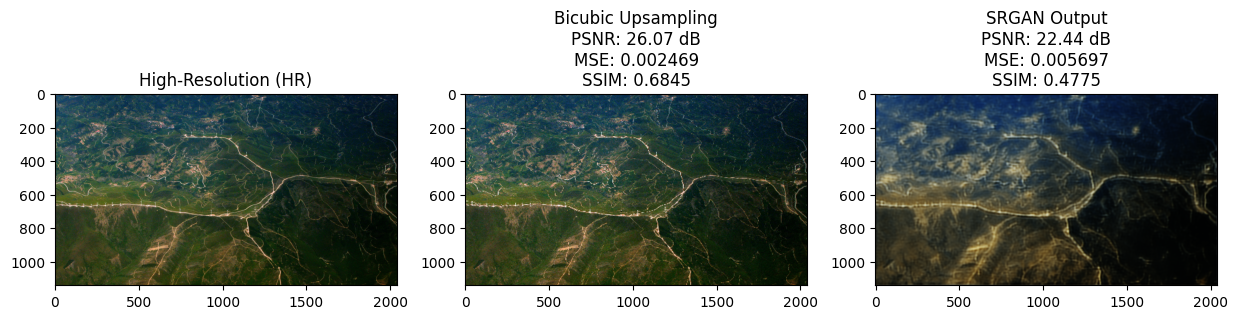


🔹 **Final Comparison:** 🔹
🔹 Bicubic PSNR: 26.07 dB | SRGAN PSNR: 22.44 dB
🔹 Bicubic SSIM: 0.6845 | SRGAN SSIM: 0.4775
❌ **SRGAN performs worse!**
[DEBUG] HR Image Shape: torch.Size([3, 1356, 2040])
[DEBUG] LR Image Shape: torch.Size([3, 339, 510])
[DEBUG] SRGAN Output Shape: torch.Size([3, 1356, 2040])


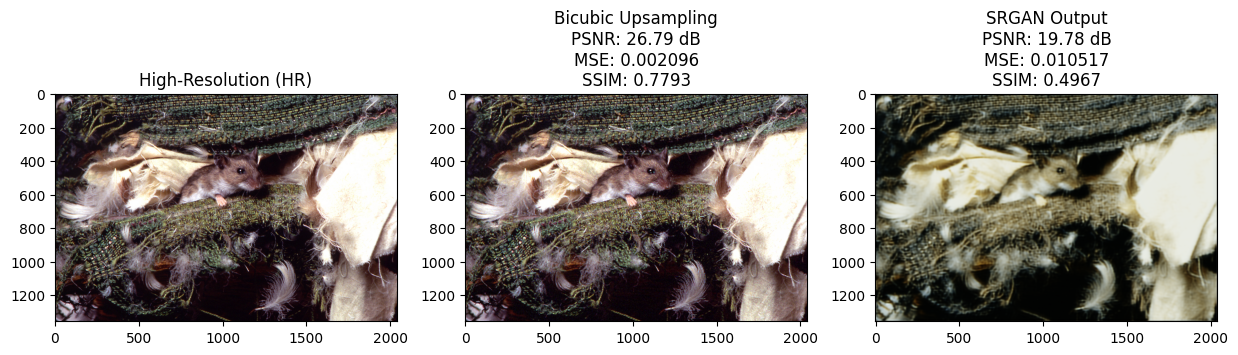


🔹 **Final Comparison:** 🔹
🔹 Bicubic PSNR: 26.79 dB | SRGAN PSNR: 19.78 dB
🔹 Bicubic SSIM: 0.7793 | SRGAN SSIM: 0.4967
❌ **SRGAN performs worse!**


In [14]:


#MSE
def mse(target, src):  #Ground truth high-resolution (HR) image (expected output).
    """Ensures input tensors are the same size before computing MSE."""
    if target.shape != src.shape:
        src = F.interpolate(src.unsqueeze(0), size=target.shape[1:], mode="bicubic", align_corners=False).squeeze(0)
    return F.mse_loss(target, src).item()

#PSNR
def psnr(target, src):
    mse_value = mse(target, src)
    if mse_value == 0:
        return float('inf')  # Avoid division by zero
    max_pixel = 1.0
    return (20 * torch.log10(torch.tensor(max_pixel) / torch.sqrt(torch.tensor(mse_value)))).item()

#SSIM
ssim_metric = StructuralSimilarityIndexMeasure(data_range=1.0).to(device)

def ssim(target, src):  #SSIM ranges from 0 to 1 (closer to 1 = better quality).
    if target.shape != src.shape:
        src = F.interpolate(src.unsqueeze(0), size=target.shape[1:], mode="bicubic", align_corners=False).squeeze(0)  #target.shape[1:]  # Extracts (Height, Width) → (128, 128)
    return ssim_metric(target.unsqueeze(0), src.unsqueeze(0)).item()

#Load the trained SRGAN generator model
def load_generator(model_path, upscale_factor=4, device="cuda"):
    model = Generator(scale_factor=upscale_factor).to(device)  # Initialize model
    model.load_state_dict(torch.load(model_path, map_location=device, weights_only=True))  # Load weights
    model.eval()  # Set to evaluation mode
    return model

#Load an image and convert it to a tensor
def load_image_as_tensor(image_path, device="cuda"):
    image = cv2.imread(image_path)
    if image is None:
        raise FileNotFoundError(f"Image not found: {image_path}")

    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB
    image = torch.tensor(image, dtype=torch.float32) / 255.0  # Normalize
    image = image.permute(2, 0, 1)  # Change shape to (C, H, W)
    return image.to(device)  #image is ready for input into SRGAN!

#Generate a low-resolution version of the image
def generate_lr_image(hr_tensor, scale_factor=4):
    hr_tensor = hr_tensor.unsqueeze(0)  # Add batch dimension
    lr_tensor = F.interpolate(hr_tensor, scale_factor=1/scale_factor, mode="bicubic", align_corners=False)
    return lr_tensor.squeeze(0)  # Remove batch dimension [ simulates real-world LR images for SRGAN testing.]

#Test the SRGAN model and compare with bicubic upsampling
def test_srgan(model, test_images, scale_factor=4, device="cuda"):
    model.eval()  # Set model to evaluation mode
    ssim_metric = StructuralSimilarityIndexMeasure(data_range=1.0).to(device)  # SSIM metric

    for img_path in test_images:
        try:
            # Load the high-resolution image
            hr_image = load_image_as_tensor(img_path, device)
            print(f"[DEBUG] HR Image Shape: {hr_image.shape}")  # Check HR image size

            # Generate the low-resolution image
            lr_image = generate_lr_image(hr_image, scale_factor)
            print(f"[DEBUG] LR Image Shape: {lr_image.shape}")  # Check LR image size

            #Bicubic Upsample the LR image
            lr_upsampled = F.interpolate(lr_image.unsqueeze(0), size=hr_image.shape[1:], mode="bicubic", align_corners=False).squeeze(0)

            #Run LR through SRGAN
            #Disables gradient tracking (saves memory & speeds up inference)., Since we are validating, not training, gradients are not needed.
            with torch.no_grad():
                sr_image = model(lr_image.unsqueeze(0)).squeeze(0)

            print(f"[DEBUG] SRGAN Output Shape: {sr_image.shape}")  # Check SR image size

            #Compute evaluation metrics
            mse_bicubic = mse(lr_upsampled, hr_image)
            psnr_bicubic = psnr(lr_upsampled, hr_image)
            ssim_bicubic = ssim(lr_upsampled, hr_image)

            mse_sr = mse(sr_image, hr_image)
            psnr_sr = psnr(sr_image, hr_image)
            ssim_sr = ssim(sr_image, hr_image)

            #Display the results
            fig, axes = plt.subplots(1, 3, figsize=(15, 5))
            axes[0].imshow(hr_image.permute(1, 2, 0).cpu())
            axes[0].set_title("High-Resolution (HR)")

            axes[1].imshow(lr_upsampled.permute(1, 2, 0).cpu())
            axes[1].set_title(f"Bicubic Upsampling\nPSNR: {psnr_bicubic:.2f} dB\nMSE: {mse_bicubic:.6f}\nSSIM: {ssim_bicubic:.4f}")

            axes[2].imshow(sr_image.permute(1, 2, 0).cpu())
            axes[2].set_title(f"SRGAN Output\nPSNR: {psnr_sr:.2f} dB\nMSE: {mse_sr:.6f}\nSSIM: {ssim_sr:.4f}")

            plt.show()

            #Compare SRGAN vs Bicubic
            print("\nFinal Comparison: ")
            print(f"Bicubic PSNR: {psnr_bicubic:.2f} dB | SRGAN PSNR: {psnr_sr:.2f} dB")
            print(f"Bicubic SSIM: {ssim_bicubic:.4f} | SRGAN SSIM: {ssim_sr:.4f}")
            print("SRGAN improves quality!" if psnr_sr > psnr_bicubic else "SRGAN performs worse!")

        except Exception as e:
            print(f"Error processing {img_path}: {e}")

#Load the model and test
device = "cuda" if torch.cuda.is_available() else "cpu"
generator = load_generator("/content/drive/MyDrive/Colab_Notebooks/srgan_pth/generator_epoch_50.pth", device=device)
test_srgan(generator, ["/content/drive/MyDrive/DIV2k/train/DIV2K_train_HR/0330.png", "/content/drive/MyDrive/DIV2k/train/DIV2K_train_HR/0339.png"], device=device)


#Overall: load test img as tensor -> generate LR img -> using bicubic to upscale it back (for comparison) -> LR img go through the SRGAN and produce the SR -> now do comparison